In [2]:

import awswrangler
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import subprocess as sp
import yaml
import seaborn as sns
import mplleaflet
from pyathena import connect
import geopandas as gpd
import folium
from pyathena.pandas.util import as_pandas
import folium
from folium.plugins import MarkerCluster
from IPython.core.display import display, HTML

# Set working to manual_update, standardize yaml and src locations
root = sp.getoutput("git rev-parse --show-toplevel")
os.chdir(os.path.join(root, "manual_flagging"))

# Inputs yaml as inputs
with open(os.path.join("yaml", "inputs_initial.yaml"), "r") as stream:
    inputs = yaml.safe_load(stream)

# Connect to athena
conn = connect(
    s3_staging_dir=os.getenv("AWS_ATHENA_S3_STAGING_DIR"),
    region_name=os.getenv("AWS_REGION"),
)

SQL_QUERY = """
SELECT
    sale.sale_price AS meta_sale_price,
    sale.sale_date AS meta_sale_date,
    sale.doc_no AS meta_sale_document_num,
    sale.sale_filter_ptax_flag,
    res.pin AS pin,
    res.class AS class,
    res.char_bldg_sf AS char_bldg_sf,
    latlong.lat AS lat,
    latlong.lon AS long
FROM default.vw_card_res_char res
INNER JOIN default.vw_pin_sale sale
    ON sale.pin = res.pin
    AND sale.year = res.year
LEFT JOIN default.vw_pin_universe latlong
    ON res.pin = latlong.pin
    AND res.year = latlong.year
WHERE (sale.sale_date
    BETWEEN DATE '2014-02-01'
    AND DATE '2021-01-31')
AND NOT sale.is_multisale
AND NOT res.pin_is_multicard;
"""

# Execute query and return as pandas df
cursor = conn.cursor()
cursor.execute(SQL_QUERY)
metadata = cursor.description
df_ingest = as_pandas(cursor)
df = df_ingest

/tmp/ipykernel_1613945/952106412.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Subset for computation
sample_size = 10000 
sampled_df = df.sample(n=sample_size, random_state=42)

def determine_color(dummy_value):
    if dummy_value == 0:
        return 'blue'
    else:
        return 'red'

m = folium.Map(location=[41.8781, -87.6298], zoom_start=10)


for _, row in sampled_df.dropna(subset=['long']).iterrows():
    lat, lon, dummy = row['lat'], row['long'], row['sale_filter_ptax_flag']
    folium.CircleMarker(
        location=[lat, lon],
        radius=1,
        color=determine_color(dummy),
        fill=True,
        fill_color=determine_color(dummy),
        fill_opacity=0.6,
    ).add_to(m)


In [4]:
m

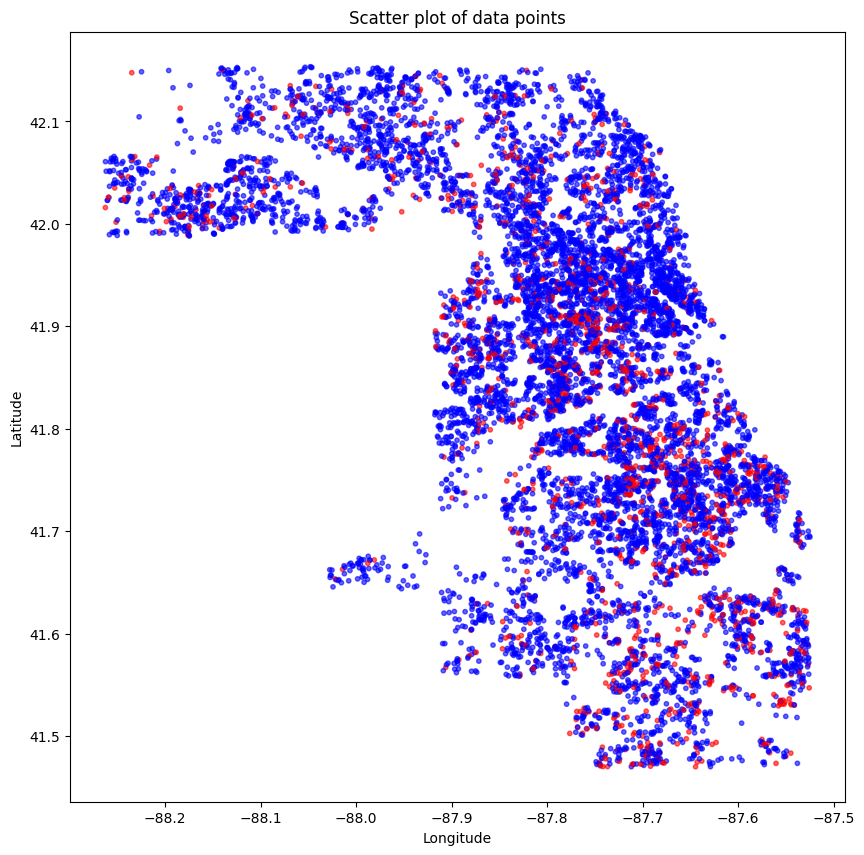

In [12]:


def determine_color(dummy_value):
    if dummy_value == 0:
        return 'blue'
    else:
        return 'red'

sampled_df = sampled_df.dropna(subset=['long'])
lats = sampled_df['lat']
longs = sampled_df['long']
colors = [determine_color(dummy) for dummy in sampled_df['sale_filter_ptax_flag']]

plt.figure(figsize=(10, 10))
plt.scatter(longs, lats, c=colors, s=10, alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter plot of data points')
plt.savefig('map_image.png', dpi=300)
plt.show()


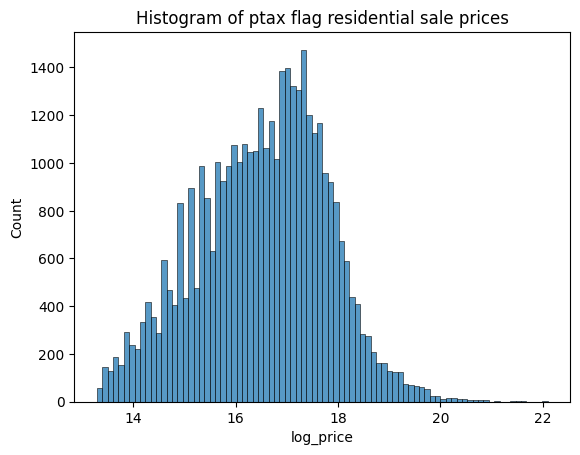

In [31]:
df['log_price'] = np.log2(df['meta_sale_price'])

sns.histplot(data=df[df['sale_filter_ptax_flag']==True], x="log_price")
plt.title('Histogram of ptax flag residential log sale prices');

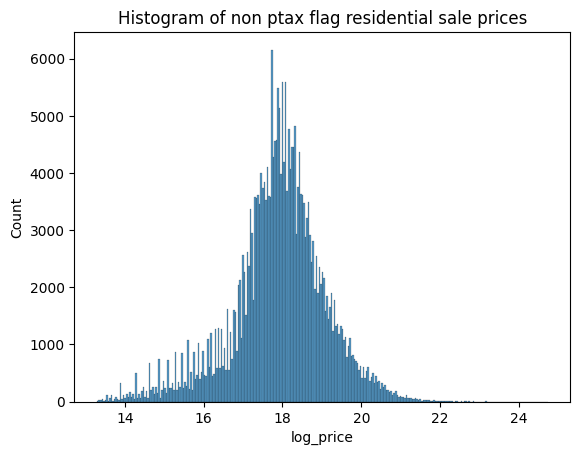

In [29]:
sns.histplot(data=df[df['sale_filter_ptax_flag']==False], x="log_price")
plt.title('Histogram of non ptax flag residential log sale prices');

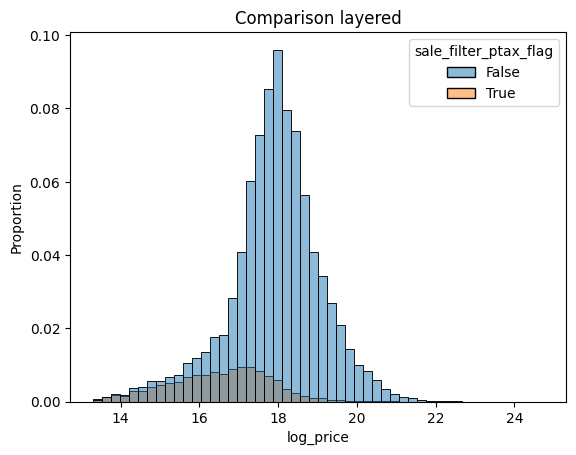

In [36]:
sns.histplot(data=df, x="log_price",
             hue='sale_filter_ptax_flag',
             stat='proportion',
             multiple='layer',
             bins=50)
             
plt.title('Comparison layered');

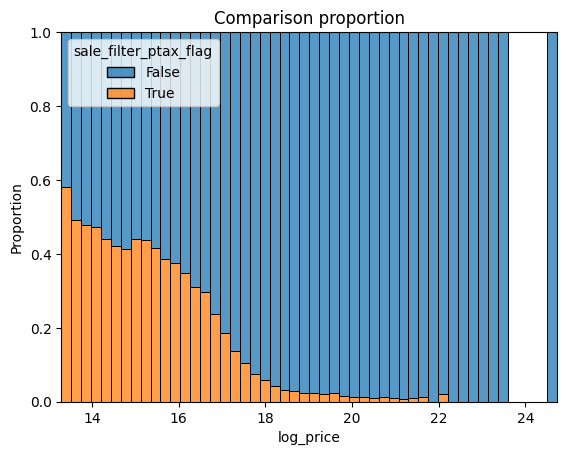

In [35]:
sns.histplot(data=df, x="log_price",
             hue='sale_filter_ptax_flag',
             stat='proportion',
             multiple='fill',
             bins=50);

plt.title('Comparison proportion');